<a href="https://colab.research.google.com/github/TaraOnGit/ML_Agorithms_Coded_NBs/blob/master/LicensePlateDetectionCroppingFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**License Plate Detection and Cropping from Vehicle Image **italicized text** **

In [ ]:
!pip install keras

#**Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Conv2D, MaxPooling2D, Dense

import cv2 #OpenCV Library
import os #
import glob #helps in finding matching file paths

1. Dropout acts as Regularization Technique and Avoids Overfitting
2. Flatten - Flattens data into 1D array
3. Conv2D - Applies 2D Convolution Filter
4. MaxPooling2d - Reduces Dimensions by Downsampling
5. Dense - Fully Connected Layer

#**Working with Data (Vehicle Images)**
##**Extracting the Zip File Content**

In [ ]:
import zipfile
zip_file = '/content/Licplatesdetection_train.zip'
extract_folder = 'lpd_images'

if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

#**Fetching the Individual Image Files from the Folder**

In [ ]:
img_dir = "/content/lpd_images/license_plates_detection_train"
data_path = os.path.join(img_dir,"*g")
files = glob.glob(data_path)

In [ ]:
files.sort()
#files

In [ ]:

X = [] # To store input images

for file in files:  #Loop through image files
  img = cv2.imread(file)  # Read the image file
  img = cv2.resize(img, (244,244))   # Resizing all image files to same size
  X.append(img) # Appending image file data to X

#**Reading the Boundary Box Values**

In [ ]:

df = pd.read_csv('/content/Licplatesdetection_train.csv')
df.head(2)

,img_id,ymin,xmin,ymax,xmax
0,1.jpg,276,94,326,169
1,10.jpg,311,395,344,444


In [ ]:
y = []

for index, row in df.iterrows():
  img_id = row['img_id']
  ymin,xmin,ymax,xmax = row['ymin'], row['xmin'], row['ymax'], row['xmax']
  y.append([ymin,xmin,ymax,xmax])

#y = np.array(y)

#**Exploring License Plates with CV2**

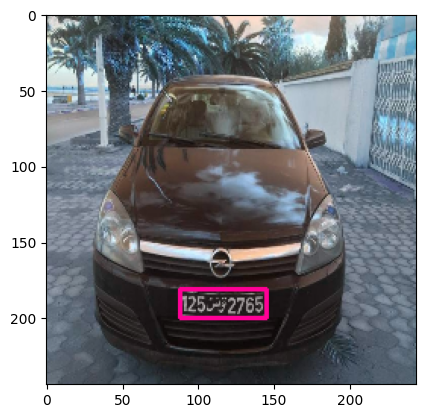

In [ ]:
ymin, xmin, ymax, xmax = y[2]

img = cv2.imread(files[2])
old_height, old_width = img.shape[:2]
lic_plate_img = cv2.rectangle(X[2],
                              (int(xmin * 244 / old_width), int(ymin *244 / old_height)),  # Top-left corner (xmin, ymin)
                              (int(xmax * 244 / old_width), int(ymax * 244 / old_height)),  # Bottom-right corner (xmax, ymax)
                              (255, 0, 150), 2)
plt.imshow(lic_plate_img)
plt.show()

1. X has images
2. y has the coordinates of bounding box of the number/license plate

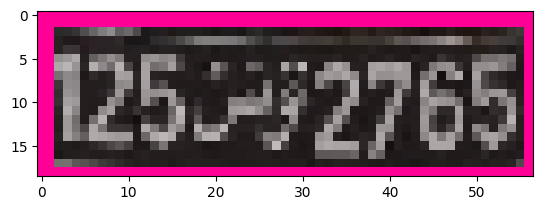

In [ ]:
top_left = (int(xmin * 244 / old_width), int(ymin * 244 / old_height))
bottom_right = (int(xmax * 244 / old_width), int(ymax * 244 / old_height))

cropped_img = lic_plate_img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

plt.imshow(cropped_img)
#cropped_img
#plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))

#**Normalizing the values of X, so that the model treats them equally**

In [ ]:
#Converting X and y to numpy arrays
X = np.array(X)
y = np.array(y)

In [ ]:
X = X / 255
y = y // 255

In [ ]:
X[0]

array([[[0.31764706, 0.3254902 , 0.3254902 ],
        [0.38823529, 0.4       , 0.4       ],
        [0.18823529, 0.19607843, 0.19607843],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.31764706, 0.32941176, 0.32941176],
        [0.2745098 , 0.28235294, 0.28235294],
        [0.28235294, 0.29019608, 0.29019608],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.30980392, 0.31764706, 0.31764706],
        [0.22745098, 0.23529412, 0.23529412],
        [0.14117647, 0.14901961, 0.14901961],
        ...,
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843]],

       ...,

       [[0.54901961, 0.54117647, 0.49803922],
        [0.55686275, 0.54901961, 0.50588235],
        [0.54509804, 0

1. Values have been normalized

---



#**Train Test Split**

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

#**Model Training - CNN**

In [ ]:
model = Sequential()

#1. Feature Extractor
#__________________

#First Convolutional Layer
model.add(Conv2D(64, (3,3), input_shape=(244,244,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

#Second Convolutional Layer
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

#2. Classification (Fully Connected Layer)
#__________________

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

train = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10,batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - accuracy: 0.2775 - loss: 67.8585 - val_accuracy: 0.0625 - val_loss: 494.5646
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.2848 - loss: 1214.9684 - val_accuracy: 0.0833 - val_loss: 3865.5898
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step - accuracy: 0.2927 - loss: 6037.6821 - val_accuracy: 0.7431 - val_loss: 9688.1729
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 146s 5s/step - accuracy: 0.3634 - loss: 9950.9873 - val_accuracy: 0.1250 - val_loss: 12202.5811
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.2188 - loss: 22985.6191 - val_accuracy: 0.0625 - val_loss: 68381.1016
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.2662 - loss: 93843.3125 - val_accuracy: 0.0625 - val_loss: 76999.8906
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.2716 - loss: 146864.4062 - val_accuracy: 0.0625 - val_loss: 158498.2500
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step - accuracy: 0.

#**Model Evalaution**

In [ ]:
scores = model.evaluate(X_test,y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.0431 - loss: 1262597.6250


In [ ]:
scores

[1294165.0, 0.06111111119389534]

#**Model Perfroamance**

1. The accuracy of model even on training data is very low indicating high bias. Therefore, the model is underfitting. We need to optimize the model's performance.
2. The accuracy of model on test data is also very low indicating very high variance. We need to improve on this also.

#**Thank You**